In [1]:
from utils import *
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()


# box = 'Box0_1400'
box = 'Box_n50_0_1400'

h = cosmo_params[box]['H0']/100

Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_Pk.pkl'
Pk_f = open(Pk_fname, 'rb')
Pkz = pickle.load(Pk_f) #Pkz is a dictonary of functions
Pk_f.close()

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

#deal with floating point errors
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))

# LOOKING_AT = [a_RUN]


N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

dlnσinvdMs = {}

vol = -1 #Mpc^3/h^3
Mpart = -1

for z in tqdm(Pkz.keys()):
    a = z_to_a[z]
#     if(a not in LOOKING_AT):
#         continue
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    M_numerics = np.logspace(np.log10(100*Mpart), 17, 200) #h^-1 Msolar
    
    
    R = [M_to_R(m, box, a) for m in M_numerics] #h^-1 Mpc
    
    
    M_log10 = np.log10(M_numerics)
    sigma2s = [sigma2(Pk, r) for r in R]
    sigma = np.sqrt(sigma2s)
    lnsigmainv = -np.log(sigma)
    dlnsinvdlogM = np.gradient(lnsigmainv, M_log10)
    
    f_dlnsinvdlogM_log = interp1d(M_log10, dlnsinvdlogM,kind='cubic')
    f_dlnsinvdM = lambda M: f_dlnsinvdlogM_log(np.log10(M)) / (M * np.log(10)) 

    dlnσinvdMs[a] = f_dlnsinvdM    
    

from scipy.special import gamma
from scipy.optimize import curve_fit
from utils import *

def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup

def tinker(a, M, 
           d0, d1,
          e0, e1,
          f0, f1,
          g0,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)
    
    R = M_to_R(M, box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pkz[a_to_z[a]], R))  
    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhom_a(box, a)/M
    oup *= dlnσinvdMs[a](M)
    return oup


from utils import *

a_list = list(NvMs.keys())

from scipy.stats import poisson
param_names = [ 'd0', 'd1',
               'e0', 'e1',
               'f0', 'f1',
               'g0','g1']


M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()


jack_covs = {a:jackknife[a][1] for a in N_data}

poisson_err = {a:np.sqrt(N_data[a]) for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a:np.diag(poisson_err[a]**2) + jack_covs[a] for a in jack_covs}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(weighted_cov[a]) for a in weighted_cov if a_to_z[a]<2}  

scale_cov = {a:np.log(np.linalg.det(weighted_cov[a])) for a in weighted_cov}


def log_prior(param_values):
    #uniform prior
    for a in N_data:
        d = p(a, param_values[0], param_values[1])
        e = p(a, param_values[2], param_values[3])
        f = p(a, param_values[4], param_values[5])
        g = p(a, param_values[6], param_values[7])
        ps = [d,e,f,g]
        for param in ps:
            if(param < 0 or param > 15):
                return -np.inf
    return 0

def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(log_prior(param_values) == -np.inf):
        return -np.inf
    
    params = dict(zip(param_names, param_values))
    tinker_fs = {}
    
    for a in N_data:
        tinker_eval = [tinker(a, M_c,**params,)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = {}
    for a in N_data:
        if(a_to_z[a] >=2):
#             print(1)
            continue
        model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
            for edge_pair in NvMs[a]['edge_pairs']
        ])
    
    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)

def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)


  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
100%|██████████| 16/16 [01:12<00:00,  4.50s/it]


In [2]:
result_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_MLFit.pkl'
result_f = open(result_fname, 'rb')
result = pickle.load(result_f)
result_f.close()

In [3]:
MLE_params = dict(zip(param_names, result['x']))

In [4]:
sampler = None
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
    sampler = pickle.load(f)

In [5]:
ndim = len(param_names)
samples = sampler.chain[:, 9000:, :].reshape((-1, ndim))
final_param_vals = np.percentile(samples,  50,axis=0)
params_final = dict(zip(param_names, final_param_vals))

In [6]:
import pyccl 
import MiraTitanHMFemulator

Ommh2 = cosmo_params[box]['ombh2'] + cosmo_params[box]['omch2']
HMFemu = MiraTitanHMFemulator.Emulator()
Omnuh2 = pyccl.neutrinos.Omeganuh2(1, m_nu=[cosmo_params[box]['nu_mass_ev']/3,
                                           cosmo_params[box]['nu_mass_ev']/3,
                                           cosmo_params[box]['nu_mass_ev']/3], T_CMB=2.7255)
fiducial_cosmo = {'Ommh2': Ommh2,
                  'Ombh2': cosmo_params[box]['ombh2'],
                  'Omnuh2': Omnuh2,
                  'n_s': cosmo_params[box]['ns'],
                  'h': h,
                  'w_0': cosmo_params[box]['w0'],
                  'w_a': 0,
                  'sigma_8': cosmo_params[box]['sigma'],
                 }

(1, 50)
[0.00000000e+00 4.70640908e+04 5.21867131e+04 3.86300246e+04
 2.81049543e+04 2.00736533e+04 1.40447275e+04 9.61955003e+03
 6.42131412e+03 4.16702235e+03 2.61469993e+03 1.56741399e+03
 8.95311961e+02 4.82940955e+02 2.44501240e+02 1.15961536e+02
 5.12775895e+01 2.11244706e+01 8.10788046e+00 2.89985322e+00
 9.66660673e-01 3.00596360e-01 8.72261977e-02 2.37973964e-02
 2.35665644e-03]


/tmp/ipykernel_17605/2057902323.py:88: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


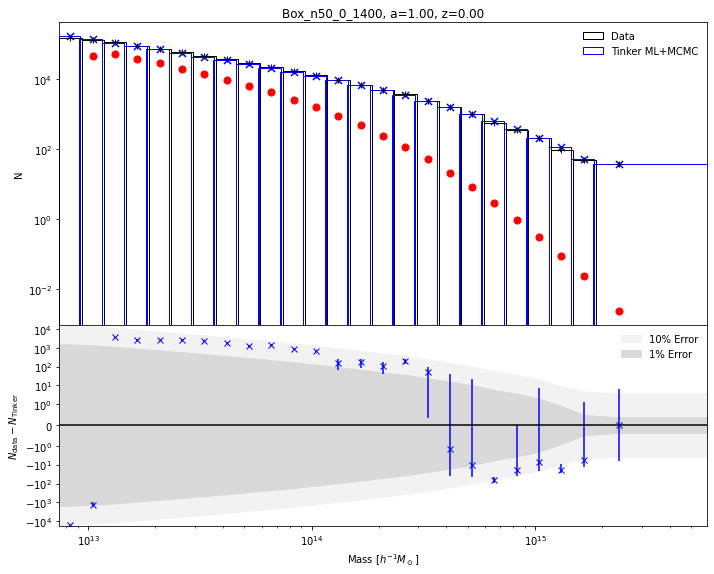

/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


(1, 50)
[0.00000000e+00 4.84591497e+04 5.39165478e+04 4.00920734e+04
 2.93243947e+04 2.10720314e+04 1.48420113e+04 1.02401493e+04
 6.89311889e+03 4.51697309e+03 2.86620868e+03 1.74050654e+03
 1.00889221e+03 5.53468799e+02 2.85686840e+02 1.38406161e+02
 6.25414735e+01 2.63291903e+01 1.03143989e+01 3.75705011e+00
 1.27259938e+00 4.01070090e-01 1.17638290e-01 3.23572187e-02
 3.21720355e-03]


/tmp/ipykernel_17605/2057902323.py:88: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


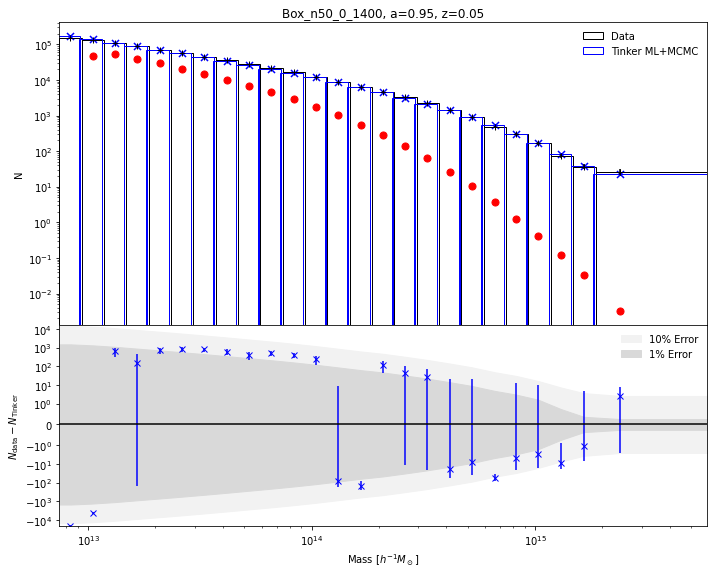

/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


(1, 50)
[0.00000000e+00 5.11681541e+04 5.72921805e+04 4.29638779e+04
 3.17381238e+04 2.30655510e+04 1.64494008e+04 1.15045998e+04
 7.86614387e+03 5.24895185e+03 3.40090346e+03 2.11546318e+03
 1.26025184e+03 7.13445033e+02 3.81792332e+02 1.92436335e+02
 9.05320409e+01 3.96820910e+01 1.61486754e+01 6.08566165e+00
 2.12363876e+00 6.86180607e-01 2.05328464e-01 6.30988667e-02]


/tmp/ipykernel_17605/2057902323.py:88: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


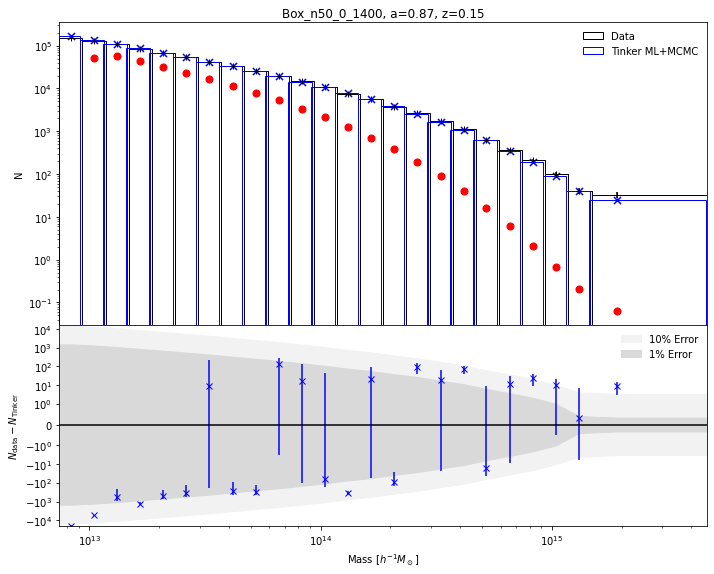

/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


(1, 50)
[0.00000000e+00 5.37614283e+04 6.05432800e+04 4.57521778e+04
 3.41039751e+04 2.50406989e+04 1.80609723e+04 1.27888950e+04
 8.86928266e+03 6.01675978e+03 3.97304634e+03 2.52598515e+03
 1.54272338e+03 8.98690098e+02 4.96967299e+02 2.59667832e+02
 1.26718657e+02 5.76176974e+01 2.42726122e+01 9.43410889e+00
 3.38232011e+00 1.11791106e+00 4.46810506e-01]


/tmp/ipykernel_17605/2057902323.py:88: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


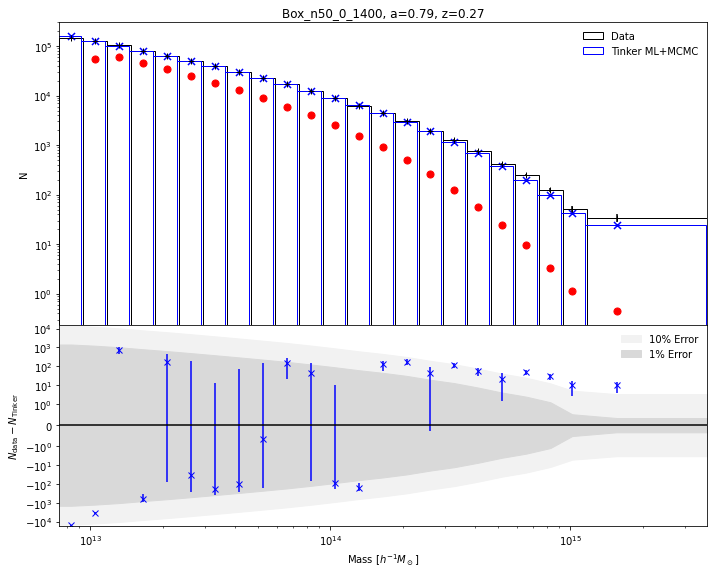

/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


(1, 50)
[0.00000000e+00 5.62321778e+04 6.36579178e+04 4.84431382e+04
 3.64069844e+04 2.69823115e+04 1.96623499e+04 1.40802090e+04
 9.89166882e+03 6.81171411e+03 4.57623861e+03 2.96790484e+03
 1.85409677e+03 1.10853147e+03 6.31576728e+02 3.40976658e+02
 1.72029974e+02 8.08702792e+01 3.51552456e+01 1.40526527e+01
 5.16339774e+00 2.45223147e+00]


/tmp/ipykernel_17605/2057902323.py:88: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


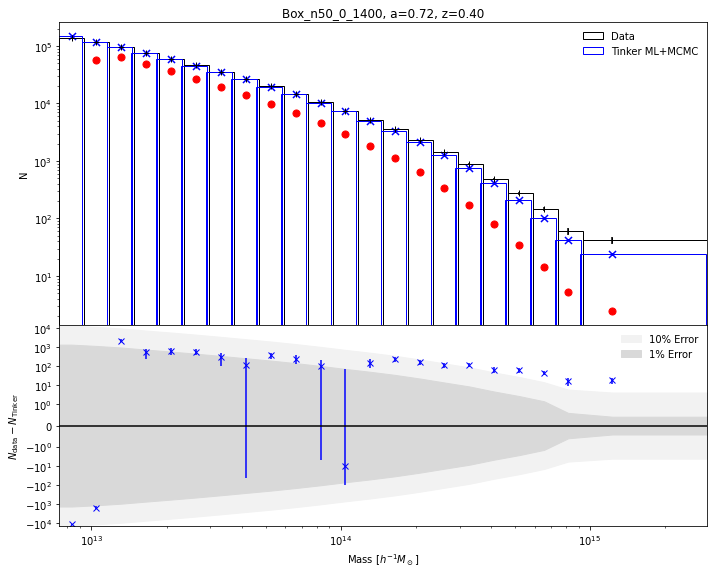

/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


(1, 50)
[0.00000000e+00 5.84956538e+04 6.65311286e+04 5.09463666e+04
 3.85685905e+04 2.88226176e+04 2.11967455e+04 1.53323356e+04
 1.08963307e+04 7.60469682e+03 5.18815499e+03 3.42481173e+03
 2.18298127e+03 1.33574151e+03 7.81587836e+02 4.34520501e+02
 2.25906235e+02 1.09458664e+02 4.89686775e+01 2.00872099e+01
 7.55155044e+00 3.65111046e+00]


/tmp/ipykernel_17605/2057902323.py:88: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


KeyboardInterrupt: 

In [7]:
from scipy.interpolate import interp1d
i=0
for a in reversed(N_data.keys()):
    z = a_to_z[a]
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']
    
    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]



    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
    dndM = (np.array(N)/vol)/dM
    
    yerr = np.sqrt(np.diagonal(weighted_cov[a])) #jackknife + poisson added in quadrature


    M_numerics_MT =np.logspace(13, 16, 50)
    tinker_eval_MCMC = [tinker(a, M_c,**params_final,)*vol for M_c in M_numerics]
    tinker_eval_MT = np.array(HMFemu.predict(fiducial_cosmo, a, M_numerics_MT))[0]
    print(np.shape(tinker_eval_MT))

    f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='cubic', bounds_error=False, fill_value=0.)
    f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
    f_dndM_MT_LOG = interp1d(np.log(M_numerics_MT), tinker_eval_MT, kind='cubic', bounds_error=False, fill_value=0.)
    f_dndM_MT = lambda x:f_dndM_MT_LOG(x)

    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])
    tinker_eval_MT = np.array([vol*quad(f_dndM_MT, np.log(edge[0]),  np.log(edge[1]))[0] for edge in edge_pairs])
    print(tinker_eval_MT)
    color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]

    

    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].scatter(Ms, tinker_eval_MT, s=50 , marker='o', c='red')

    edges = np.array(edges)
    tmp = edges[:-1]*10**(0.01)-edges[:-1]
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
               align='edge', fill=False, ec='black', label='Data')
    axs[0].bar(x=edges[:-1]-tmp, height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker ML+MCMC')
    axs[1].errorbar(Ms, (N-tinker_eval_MCMC), yerr, fmt='x', color='blue')
    
    
    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)

    y1 = 0.1*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='10% Error')

    y1 = 0.01*np.array(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.array(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)
    
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='1% Error')
    

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'${N_{\rm data}-N_{\rm Tinker}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, a_to_z[a]))
    i+=1
    
    axs[0].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_xlim((200*Mpart, np.max(edges)))

    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_ML+MCMCFits_a%.2f.pdf'%(box, a), bbox_inches='tight')
    plt.show()


In [ ]:
M_numerics_MT